In [2]:
import numpy as np
import math as mt
from sao.functions._functions import *
from sao.functions.telescope import *
from sao.functions.zernike import *
import matplotlib.pyplot as plt

In [2]:
nPx = [6,3]
dxy = [1,.1]
offset=[0,0]
def get_coordinates(nPx, dxy, offset=[0,0]): 
    if isinstance(nPx, (int, float)):
        nPx = np.array([nPx, nPx])
    if isinstance(dxy, (int, float)):
        dxy = np.array([dxy, dxy])
    if isinstance(offset, (int,float)):
        offset = np.array([offset,offset])
    #
    x = np.linspace( -(nPx[0]-1)//2, (nPx[0]-1)//2, nPx[0] )
    y = np.linspace( -(nPx[1]-1)//2, (nPx[1]-1)//2, nPx[1] ) 
    # adjusted performed to achieve a right-hand positive assumption
    x,y = (x-offset[0])*dxy[0], (y-offset[1])*dxy[1]
    Y,X = np.meshgrid(y,x, indexing='ij')
    # ^> positive assumption 
    R,O = cart2pol(X,Y)
    return X,Y,R,O
X,Y,R,O = get_coordinates(nPx,dxy,offset=[0,0])
print(Y)

[[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
 [ 0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.1  0.1  0.1  0.1  0.1]]


In [3]:
n=4
print(np.linspace(-(n-1)//2,(n-1)//2,n))

[-2. -1.  0.  1.]


------------------------------------------------ ZERNIKE class ------------------------------------------------
nPx=128 | jModes=[2, 3] | norm=
---------------------------------------------------------------------------------------------------------------


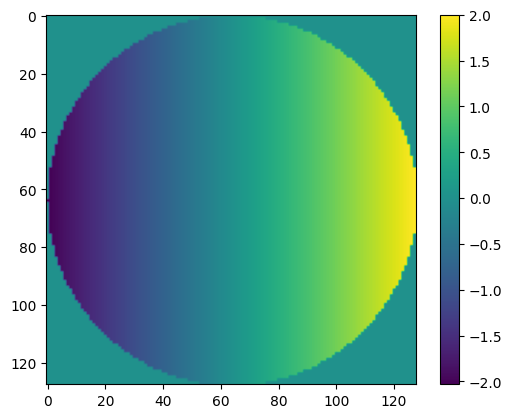

In [3]:
nPx = 128# in pixels
dxy = 1/(nPx)# in meters
D = (nPx)*dxy# in meters
tel = Telescope(nPx,D,dxy=dxy,fov=0,offset=[0,0],shape='circ')
#plt.imshow(tel.pupil)
zern = Zernike(tel)
z = zern.zModes[0,:].reshape(128,128)
plt.imshow(z)
plt.colorbar()

In [5]:
print(zern)

------------------------------------------------ ZERNIKE class ------------------------------------------------
nPx=128 | jModes=[4] | norm=pm1
---------------------------------------------------------------------------------------------------------------



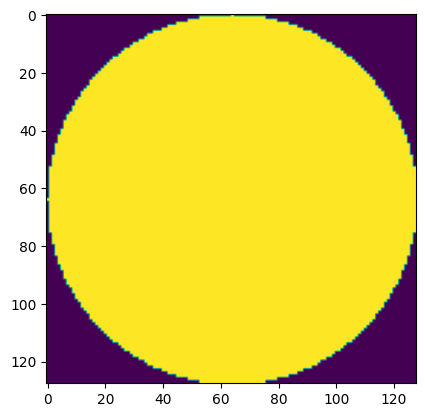

In [4]:
z = zern.get_zernikes(0,0)
plt.imshow(z.squeeze())